### Check GPU availability

**NOTE:** **YOLOv12 leverages FlashAttention to speed up attention-based computations, but this feature requires an Nvidia GPU built on the Ampere architecture or newer—for example, GPUs like the RTX 3090, RTX 3080, or even the Nvidia L4 meet this requirement.**

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Fri Oct 31 05:40:41 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   57C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/content


### Install dependencies

**NOTE:** Currently, YOLOv12 does not have its own PyPI package, so we install it directly from GitHub while also adding roboflow (to conveniently pull datasets from the Roboflow Universe), supervision (to visualize inference results and benchmark the model’s performance), and flash-attn (to accelerate attention-based computations via optimized CUDA kernels).

In [3]:
!pip install -q git+https://github.com/sunsmarterjie/yolov12.git roboflow supervision flash-attn

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 84.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.2/207.2 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 83.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 117.7 MB/s eta 0:00:00


### Download example data

Let's download an image we can use for YOLOv12 inference. Feel free to drag and drop your own images into the Files tab on the left-hand side of Google Colab, then reference their filenames in your code for a custom inference demo.

In [4]:
!wget https://media.roboflow.com/notebooks/examples/dog.jpeg

--2025-10-31 05:41:45--  https://media.roboflow.com/notebooks/examples/dog.jpeg
Resolving media.roboflow.com (media.roboflow.com)... 34.110.133.209
Connecting to media.roboflow.com (media.roboflow.com)|34.110.133.209|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106055 (104K) [image/jpeg]
Saving to: ‘dog.jpeg’

dog.jpeg            100%[===================>] 103.57K  --.-KB/s    in 0.002s  

2025-10-31 05:41:45 (45.3 MB/s) - ‘dog.jpeg’ saved [106055/106055]



## Run inference

In the example, we're using the `yolov12l.pt` model, but you can experiment with different model sizes by simply swapping out the model name during initialization. Options include `yolov12n.pt`, `yolov12s.pt`, `yolov12m.pt`, `yolov12l.pt`, and `yolov12x.pt`.

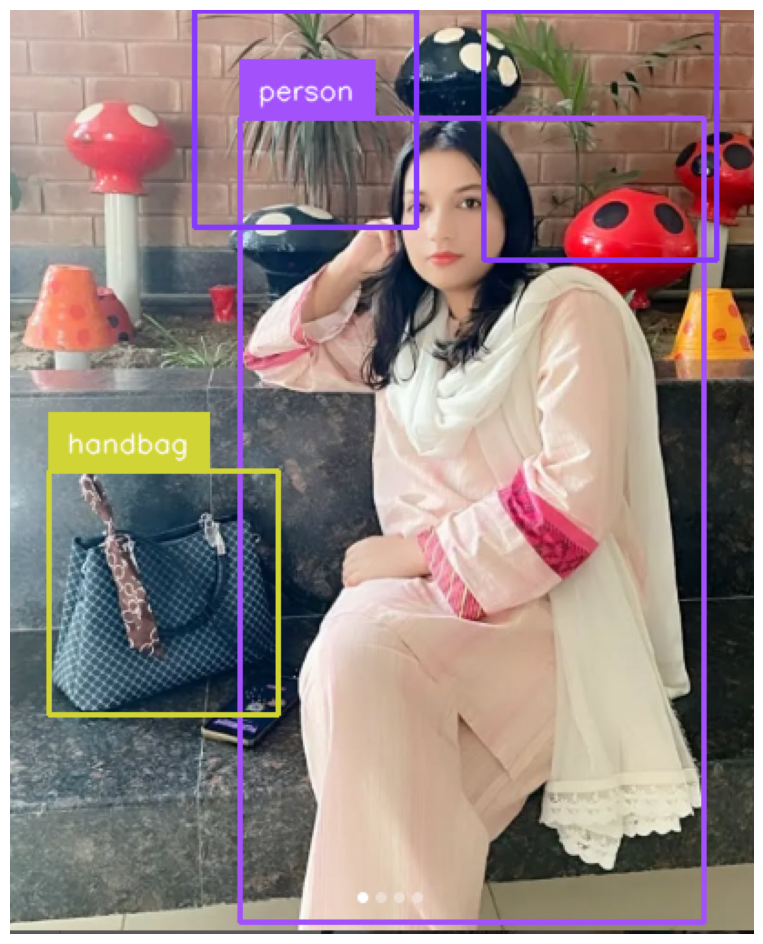

In [7]:
import cv2
from ultralytics import YOLO
import supervision as sv


image_path = f"{HOME}/testing.png"
image = cv2.imread(image_path)

model = YOLO('yolov12l.pt')

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results)

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

## Download dataset from Roboflow Universe

In [8]:


!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="NqjtCN1BkDxTg2u1jXzs")
project = rf.workspace("augmented-startups").project("weeds-nxe1w")
version = project.version(3)
dataset = version.download("yolov11")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Weeds-3 in yolov11:: 100%|██████████| 8418/8418 [00:01<00:00, 5368.54it/s]


In [9]:
!ls {dataset.location}

data.yaml  README.dataset.txt  README.roboflow.txt  test  train  valid


**NOTE:** We need to make a few changes to our downloaded dataset so it will work with YOLOv12. Run the following bash commands to prepare your dataset for training by updating the relative paths in the `data.yaml` file, ensuring it correctly points to the subdirectories for your dataset's `train`, `test`, and `valid` subsets.

In [10]:
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!echo -e "test: ../test/images\ntrain: ../train/images\nval: ../valid/images" >> {dataset.location}/data.yaml

In [11]:
!cat {dataset.location}/data.yaml

train: ../train/images
val: ../valid/images
test: ../test/images

nc: 1
names: ['Weeds']

roboflow:
  workspace: augmented-startups
test: ../test/images
train: ../train/images
val: ../valid/images


## Fine-tune YOLOv12 model

We are now ready to fine-tune our YOLOv12 model. In the code below, we initialize the model using a starting checkpoint—here, we use `yolov12s.yaml`, but you can replace it with any other model (e.g., `yolov12n.pt`, `yolov12m.pt`, `yolov12l.pt`, or `yolov12x.pt`) based on your preference. We set the training to run for 100 epochs in this example; however, you should adjust the number of epochs along with other hyperparameters such as batch size, image size, and augmentation settings (scale, mosaic, mixup, and copy-paste) based on your hardware capabilities and dataset size.

**Note:** **Note that after training, you might encounter a `TypeError: argument of type 'PosixPath' is not iterable error` — this is a known issue, but your model weights will still be saved, so you can safely proceed to running inference.**

In [12]:
from ultralytics import YOLO

model = YOLO('yolov12s.yaml')

results = model.train(data=f'{dataset.location}/data.yaml', epochs=100)

New https://pypi.org/project/ultralytics/8.3.223 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.63 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov12s.yaml, data=/content/Weeds-3/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_fr

100%|██████████| 755k/755k [00:00<00:00, 23.1MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1      9344  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2, 1, 2]          
  2                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  3                  -1  1     37120  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2, 1, 4]        
  4                  -1  1    103360  ultralytics.nn.modules.block.C3k2            [128, 256, 1, False, 0.25]    
  5                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  6                  -1  2    677120  ultralytics.nn.modules.block.A2C2f           [256, 256, 2, True, 4]        
  7                  -1  1   1180672  ultralytics

100%|██████████| 5.26M/5.26M [00:00<00:00, 102MB/s]


AMP: checks passed ✅


train: Scanning /content/Weeds-3/train/labels... 3664 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3664/3664 [00:01<00:00, 2275.13it/s]


train: New cache created: /content/Weeds-3/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


Argument(s) 'quality_lower' are not valid for transform ImageCompression
val: Scanning /content/Weeds-3/valid/labels... 359 images, 0 backgrounds, 0 corrupt: 100%|██████████| 359/359 [00:00<00:00, 1366.06it/s]

val: New cache created: /content/Weeds-3/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 121 weight(decay=0.0), 128 weight(decay=0.0005), 127 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      7.04G      2.962      3.371      3.703         99        640: 100%|██████████| 229/229 [02:18<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:13<00:00,  1.12s/it]

                   all        359        920      0.163      0.224     0.0883     0.0278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      6.78G      2.373      2.548      2.857         63        640: 100%|██████████| 229/229 [02:02<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.34it/s]


                   all        359        920      0.329      0.421      0.282      0.107

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      6.96G      2.074      2.193       2.51         89        640: 100%|██████████| 229/229 [02:01<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.35it/s]

                   all        359        920      0.431      0.425       0.43      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      6.78G      1.943      2.017      2.339         87        640: 100%|██████████| 229/229 [02:00<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.65it/s]

                   all        359        920      0.585      0.486      0.538      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      6.98G       1.86      1.903      2.222         66        640: 100%|██████████| 229/229 [02:00<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.65it/s]

                   all        359        920      0.565      0.564      0.597       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      6.79G       1.79       1.81      2.137         67        640: 100%|██████████| 229/229 [02:00<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.37it/s]

                   all        359        920      0.648       0.62      0.654       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      6.77G      1.735       1.73      2.077         61        640: 100%|██████████| 229/229 [02:00<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.39it/s]


                   all        359        920      0.646      0.648      0.673      0.323

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      6.78G      1.683       1.66       2.03         94        640: 100%|██████████| 229/229 [02:00<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.67it/s]

                   all        359        920      0.696      0.571      0.652       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      6.99G      1.639      1.606      1.987         68        640: 100%|██████████| 229/229 [02:01<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]

                   all        359        920      0.752       0.59      0.698      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      6.98G      1.621      1.565      1.945         72        640: 100%|██████████| 229/229 [02:00<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.33it/s]

                   all        359        920      0.762      0.651      0.753      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      6.95G      1.572      1.504      1.917         59        640: 100%|██████████| 229/229 [02:00<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]

                   all        359        920      0.753      0.645      0.739      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      6.75G      1.562      1.469      1.895        103        640: 100%|██████████| 229/229 [02:01<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.65it/s]

                   all        359        920      0.823      0.657      0.771      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      6.96G      1.534       1.43      1.865         81        640: 100%|██████████| 229/229 [02:01<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.34it/s]

                   all        359        920      0.779      0.653      0.762      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      6.96G      1.513      1.387      1.832         43        640: 100%|██████████| 229/229 [02:00<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.40it/s]


                   all        359        920      0.823      0.722       0.81      0.453

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      6.96G      1.493      1.339      1.809         68        640: 100%|██████████| 229/229 [02:00<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.67it/s]

                   all        359        920      0.827      0.738      0.829      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      6.78G      1.484      1.336      1.806        105        640: 100%|██████████| 229/229 [02:01<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.64it/s]

                   all        359        920      0.843      0.716      0.839      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      6.97G      1.444      1.292      1.775         72        640: 100%|██████████| 229/229 [02:00<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.30it/s]

                   all        359        920      0.802      0.738      0.819      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      6.96G      1.438      1.275      1.758         56        640: 100%|██████████| 229/229 [02:00<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]

                   all        359        920      0.843      0.757      0.852      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      6.96G      1.417      1.242       1.73         78        640: 100%|██████████| 229/229 [02:00<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.70it/s]

                   all        359        920      0.844      0.775      0.869      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100       6.8G      1.413      1.211      1.717         73        640: 100%|██████████| 229/229 [02:00<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.32it/s]

                   all        359        920      0.852       0.76      0.867      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      6.96G      1.395      1.198      1.703         74        640: 100%|██████████| 229/229 [02:00<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.62it/s]


                   all        359        920      0.869      0.738      0.843      0.505

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      6.96G      1.387      1.185      1.698         57        640: 100%|██████████| 229/229 [02:00<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]

                   all        359        920      0.858      0.768      0.874      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      6.96G      1.378      1.168      1.694         92        640: 100%|██████████| 229/229 [02:00<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.32it/s]

                   all        359        920      0.873      0.806      0.891      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      6.77G      1.356       1.14      1.668         76        640: 100%|██████████| 229/229 [02:00<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.51it/s]

                   all        359        920      0.831      0.818      0.886      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      6.97G       1.34      1.132      1.658         86        640: 100%|██████████| 229/229 [02:00<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.70it/s]

                   all        359        920      0.869      0.779      0.881      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      6.96G      1.334      1.101      1.648        114        640: 100%|██████████| 229/229 [02:01<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.59it/s]

                   all        359        920      0.854      0.795      0.892      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      6.81G      1.331      1.087      1.639         97        640: 100%|██████████| 229/229 [02:00<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.38it/s]

                   all        359        920      0.872      0.815      0.897      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      6.78G      1.324      1.081      1.621         77        640: 100%|██████████| 229/229 [02:00<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.67it/s]

                   all        359        920      0.842      0.833      0.898      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      6.96G      1.304      1.056      1.613         74        640: 100%|██████████| 229/229 [02:00<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.70it/s]

                   all        359        920      0.875      0.848      0.917      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      6.96G      1.299      1.037      1.605         92        640: 100%|██████████| 229/229 [02:00<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.38it/s]

                   all        359        920      0.886      0.826       0.91      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      6.94G      1.291      1.042       1.61         66        640: 100%|██████████| 229/229 [02:00<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.70it/s]

                   all        359        920      0.865      0.872      0.927        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100       6.8G      1.277       1.02      1.587         68        640: 100%|██████████| 229/229 [02:01<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.70it/s]

                   all        359        920      0.904      0.827      0.927       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      6.95G      1.275      1.008      1.582        111        640: 100%|██████████| 229/229 [02:00<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.39it/s]

                   all        359        920      0.902      0.816      0.913      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      6.96G      1.268      1.002       1.58         92        640: 100%|██████████| 229/229 [01:59<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.70it/s]

                   all        359        920       0.88      0.845      0.927      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      6.81G      1.266     0.9878      1.577         90        640: 100%|██████████| 229/229 [01:59<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.58it/s]

                   all        359        920      0.878      0.866      0.929      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      6.77G       1.25     0.9684      1.551         55        640: 100%|██████████| 229/229 [01:59<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.41it/s]


                   all        359        920      0.886      0.865      0.934      0.624

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      6.96G       1.25     0.9677      1.557         62        640: 100%|██████████| 229/229 [01:59<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.73it/s]

                   all        359        920      0.892       0.87      0.936      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      6.98G      1.231     0.9372      1.541         61        640: 100%|██████████| 229/229 [01:59<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.53it/s]

                   all        359        920      0.888      0.848      0.929      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      6.98G      1.225     0.9425       1.53         93        640: 100%|██████████| 229/229 [01:59<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.56it/s]

                   all        359        920      0.898      0.846       0.93      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      6.77G      1.222      0.934      1.528         52        640: 100%|██████████| 229/229 [01:59<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.71it/s]

                   all        359        920       0.89       0.87      0.938      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      6.79G      1.214     0.9147      1.514         64        640: 100%|██████████| 229/229 [01:59<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.35it/s]

                   all        359        920      0.882      0.866      0.935      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      6.79G      1.209     0.9177      1.523         98        640: 100%|██████████| 229/229 [01:59<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.61it/s]


                   all        359        920      0.897      0.869      0.937      0.651

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      6.96G      1.197     0.8932      1.503         58        640: 100%|██████████| 229/229 [01:59<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.73it/s]

                   all        359        920      0.906      0.873       0.94      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      6.78G      1.202     0.9077      1.518         78        640: 100%|██████████| 229/229 [01:59<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.37it/s]

                   all        359        920      0.904      0.863      0.937      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      6.96G       1.19     0.8986        1.5         50        640: 100%|██████████| 229/229 [01:59<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.63it/s]

                   all        359        920      0.913      0.866      0.943      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      6.96G      1.182     0.8666      1.492         65        640: 100%|██████████| 229/229 [01:59<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.72it/s]

                   all        359        920      0.891      0.877      0.946      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      6.94G      1.176     0.8861      1.502         89        640: 100%|██████████| 229/229 [01:59<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.39it/s]

                   all        359        920      0.914      0.887      0.949      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100       6.8G      1.177     0.8634      1.479        102        640: 100%|██████████| 229/229 [01:59<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.71it/s]

                   all        359        920      0.907       0.89      0.949      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      6.93G      1.163     0.8463      1.473         51        640: 100%|██████████| 229/229 [01:59<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.72it/s]

                   all        359        920      0.904      0.905      0.951      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100         7G      1.159     0.8487      1.466         63        640: 100%|██████████| 229/229 [01:59<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.44it/s]

                   all        359        920      0.899       0.89      0.954      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      6.96G      1.154     0.8417      1.456         86        640: 100%|██████████| 229/229 [01:59<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.02it/s]

                   all        359        920      0.882        0.9       0.95      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      6.75G      1.144     0.8409      1.459         89        640: 100%|██████████| 229/229 [02:02<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.72it/s]

                   all        359        920      0.893      0.898      0.949       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      6.99G      1.127     0.8285      1.449         76        640: 100%|██████████| 229/229 [01:59<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.45it/s]

                   all        359        920      0.922      0.884      0.953        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      6.96G      1.112     0.8189       1.43         80        640: 100%|██████████| 229/229 [01:59<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.72it/s]

                   all        359        920      0.912      0.893      0.954      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      6.99G      1.114      0.806      1.431         72        640: 100%|██████████| 229/229 [01:59<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.39it/s]

                   all        359        920      0.921      0.886      0.959      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100       6.8G      1.108     0.8195      1.432         72        640: 100%|██████████| 229/229 [01:59<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.70it/s]

                   all        359        920      0.912      0.907      0.956      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      6.79G      1.088     0.7982      1.418         72        640: 100%|██████████| 229/229 [02:00<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.74it/s]

                   all        359        920      0.911      0.889      0.955      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      6.78G      1.083     0.7808      1.409         87        640: 100%|██████████| 229/229 [01:59<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.39it/s]

                   all        359        920       0.92      0.894      0.957      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      6.96G      1.085     0.7842      1.407         67        640: 100%|██████████| 229/229 [01:59<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.63it/s]


                   all        359        920      0.932      0.888      0.959      0.711

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100       6.8G      1.063      0.767      1.395         77        640: 100%|██████████| 229/229 [01:59<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.71it/s]

                   all        359        920        0.9      0.927      0.958      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      6.98G      1.077     0.7677      1.396         74        640: 100%|██████████| 229/229 [01:59<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.37it/s]

                   all        359        920      0.916      0.897      0.962      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      6.81G      1.061      0.762       1.39         50        640: 100%|██████████| 229/229 [01:59<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.71it/s]

                   all        359        920      0.907      0.917      0.959      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      6.81G      1.061      0.763      1.386         72        640: 100%|██████████| 229/229 [01:59<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.73it/s]

                   all        359        920      0.927      0.895      0.958      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      6.78G      1.046     0.7507      1.375         65        640: 100%|██████████| 229/229 [01:59<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.41it/s]

                   all        359        920      0.919      0.904      0.957      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      6.96G      1.042     0.7471      1.377         78        640: 100%|██████████| 229/229 [01:59<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.73it/s]

                   all        359        920      0.905      0.907      0.962      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      6.78G      1.036     0.7506      1.374         45        640: 100%|██████████| 229/229 [01:59<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.72it/s]

                   all        359        920      0.937      0.893      0.962      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      6.81G      1.034     0.7373      1.374         77        640: 100%|██████████| 229/229 [01:59<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.44it/s]

                   all        359        920      0.901      0.925      0.964      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      6.77G      1.033     0.7237      1.356         66        640: 100%|██████████| 229/229 [01:59<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.72it/s]

                   all        359        920      0.935      0.903      0.967      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      6.79G      1.026      0.726       1.36         65        640: 100%|██████████| 229/229 [01:59<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.49it/s]

                   all        359        920      0.929      0.909      0.964      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      6.79G      1.018     0.7226      1.356         52        640: 100%|██████████| 229/229 [01:59<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.50it/s]

                   all        359        920      0.909      0.925      0.963      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      6.96G      1.015      0.722      1.353         64        640: 100%|██████████| 229/229 [01:59<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.73it/s]

                   all        359        920      0.925      0.908      0.963      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      6.77G      1.008     0.7119       1.35         67        640: 100%|██████████| 229/229 [01:59<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.49it/s]

                   all        359        920      0.918      0.923      0.967      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      6.98G      1.004     0.7053      1.338         62        640: 100%|██████████| 229/229 [01:59<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.43it/s]


                   all        359        920      0.899      0.942       0.97      0.725

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      6.81G      1.002     0.7115      1.336         82        640: 100%|██████████| 229/229 [01:59<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.73it/s]

                   all        359        920      0.933      0.907      0.964      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      6.81G     0.9959     0.7002      1.334         68        640: 100%|██████████| 229/229 [01:59<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.51it/s]

                   all        359        920      0.932      0.897      0.965      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      6.78G      0.983     0.6938      1.325         72        640: 100%|██████████| 229/229 [02:00<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.71it/s]

                   all        359        920      0.913      0.922      0.964      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      6.78G     0.9796     0.6869      1.326         52        640: 100%|██████████| 229/229 [01:59<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.40it/s]

                   all        359        920      0.923      0.915      0.967      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      6.82G     0.9805     0.6883      1.326         67        640: 100%|██████████| 229/229 [02:00<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.71it/s]

                   all        359        920      0.937      0.908      0.968       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      6.79G     0.9854     0.6908      1.327         60        640: 100%|██████████| 229/229 [02:00<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.45it/s]

                   all        359        920      0.946      0.912       0.97      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      6.78G     0.9696     0.6695       1.31         93        640: 100%|██████████| 229/229 [01:59<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.73it/s]

                   all        359        920       0.93      0.929      0.968      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      6.79G     0.9746     0.6708      1.312         80        640: 100%|██████████| 229/229 [01:59<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.45it/s]

                   all        359        920      0.927      0.927      0.971      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      6.79G     0.9695     0.6698      1.311         86        640: 100%|██████████| 229/229 [01:59<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.60it/s]


                   all        359        920      0.915       0.93       0.97      0.749

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      6.98G     0.9621     0.6725      1.304         81        640: 100%|██████████| 229/229 [01:59<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.72it/s]

                   all        359        920      0.926      0.927      0.969      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      6.77G     0.9525     0.6631      1.302         59        640: 100%|██████████| 229/229 [01:59<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.39it/s]

                   all        359        920      0.928      0.927      0.969      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      6.81G     0.9583     0.6699       1.31         77        640: 100%|██████████| 229/229 [01:59<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.74it/s]

                   all        359        920      0.939      0.917      0.971      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      6.79G     0.9498     0.6538      1.297         47        640: 100%|██████████| 229/229 [02:00<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.69it/s]

                   all        359        920      0.924       0.93       0.97      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      6.78G     0.9393     0.6448       1.28         81        640: 100%|██████████| 229/229 [01:59<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.41it/s]

                   all        359        920      0.935      0.925      0.969      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      6.78G     0.9421     0.6458      1.286         77        640: 100%|██████████| 229/229 [01:59<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.72it/s]

                   all        359        920      0.927      0.927       0.97      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      6.76G     0.9427     0.6507      1.288         72        640: 100%|██████████| 229/229 [01:59<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.44it/s]

                   all        359        920      0.932      0.921       0.97      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      6.76G     0.9248     0.6408       1.28         68        640: 100%|██████████| 229/229 [01:59<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.43it/s]


                   all        359        920      0.938       0.92       0.97      0.752
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


Argument(s) 'quality_lower' are not valid for transform ImageCompression



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      6.81G     0.8802     0.5172      1.246         33        640: 100%|██████████| 229/229 [01:59<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.58it/s]


                   all        359        920       0.94      0.923       0.97      0.745

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      6.75G     0.8467       0.49       1.22         54        640: 100%|██████████| 229/229 [01:58<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.71it/s]

                   all        359        920      0.945      0.922      0.971      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      6.96G      0.837     0.4834      1.213         35        640: 100%|██████████| 229/229 [01:58<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.73it/s]

                   all        359        920      0.933      0.933      0.972      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      6.79G     0.8429     0.4834      1.212         40        640: 100%|██████████| 229/229 [01:58<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.53it/s]

                   all        359        920      0.937       0.94      0.972      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      6.95G     0.8261     0.4696      1.204         22        640: 100%|██████████| 229/229 [01:58<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.44it/s]

                   all        359        920      0.928       0.94      0.972      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      6.75G     0.8226     0.4721        1.2         41        640: 100%|██████████| 229/229 [01:58<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.72it/s]

                   all        359        920      0.937      0.932      0.972      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      6.94G     0.8231     0.4657        1.2         33        640: 100%|██████████| 229/229 [01:59<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.71it/s]

                   all        359        920       0.93       0.94      0.972      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      6.93G     0.8183      0.468      1.197         40        640: 100%|██████████| 229/229 [01:58<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.45it/s]

                   all        359        920      0.938      0.936      0.972      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      6.94G      0.822     0.4716      1.199         39        640: 100%|██████████| 229/229 [01:58<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.41it/s]


                   all        359        920      0.932      0.936      0.972      0.763

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      6.75G     0.8147     0.4627      1.193         25        640: 100%|██████████| 229/229 [01:58<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]

                   all        359        920      0.935      0.934      0.972      0.761



100 epochs completed in 3.506 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 18.6MB
Optimizer stripped from runs/detect/train/weights/best.pt, 18.6MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.63 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12s summary (fused): 376 layers, 9,074,595 parameters, 0 gradients, 19.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:06<00:00,  1.94it/s]


                   all        359        920      0.929      0.936      0.972      0.762
Speed: 0.2ms preprocess, 8.6ms inference, 0.0ms loss, 2.9ms postprocess per image
Results saved to runs/detect/train


## Evaluate fine-tuned YOLOv12 model

In [13]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!ls {HOME}/runs/detect/train/

args.yaml					   train_batch1.jpg
confusion_matrix_normalized.png			   train_batch20610.jpg
confusion_matrix.png				   train_batch20611.jpg
events.out.tfevents.1761889936.88258adbccee.334.0  train_batch20612.jpg
F1_curve.png					   train_batch2.jpg
labels_correlogram.jpg				   val_batch0_labels.jpg
labels.jpg					   val_batch0_pred.jpg
P_curve.png					   val_batch1_labels.jpg
PR_curve.png					   val_batch1_pred.jpg
R_curve.png					   val_batch2_labels.jpg
results.csv					   val_batch2_pred.jpg
results.png					   weights
train_batch0.jpg


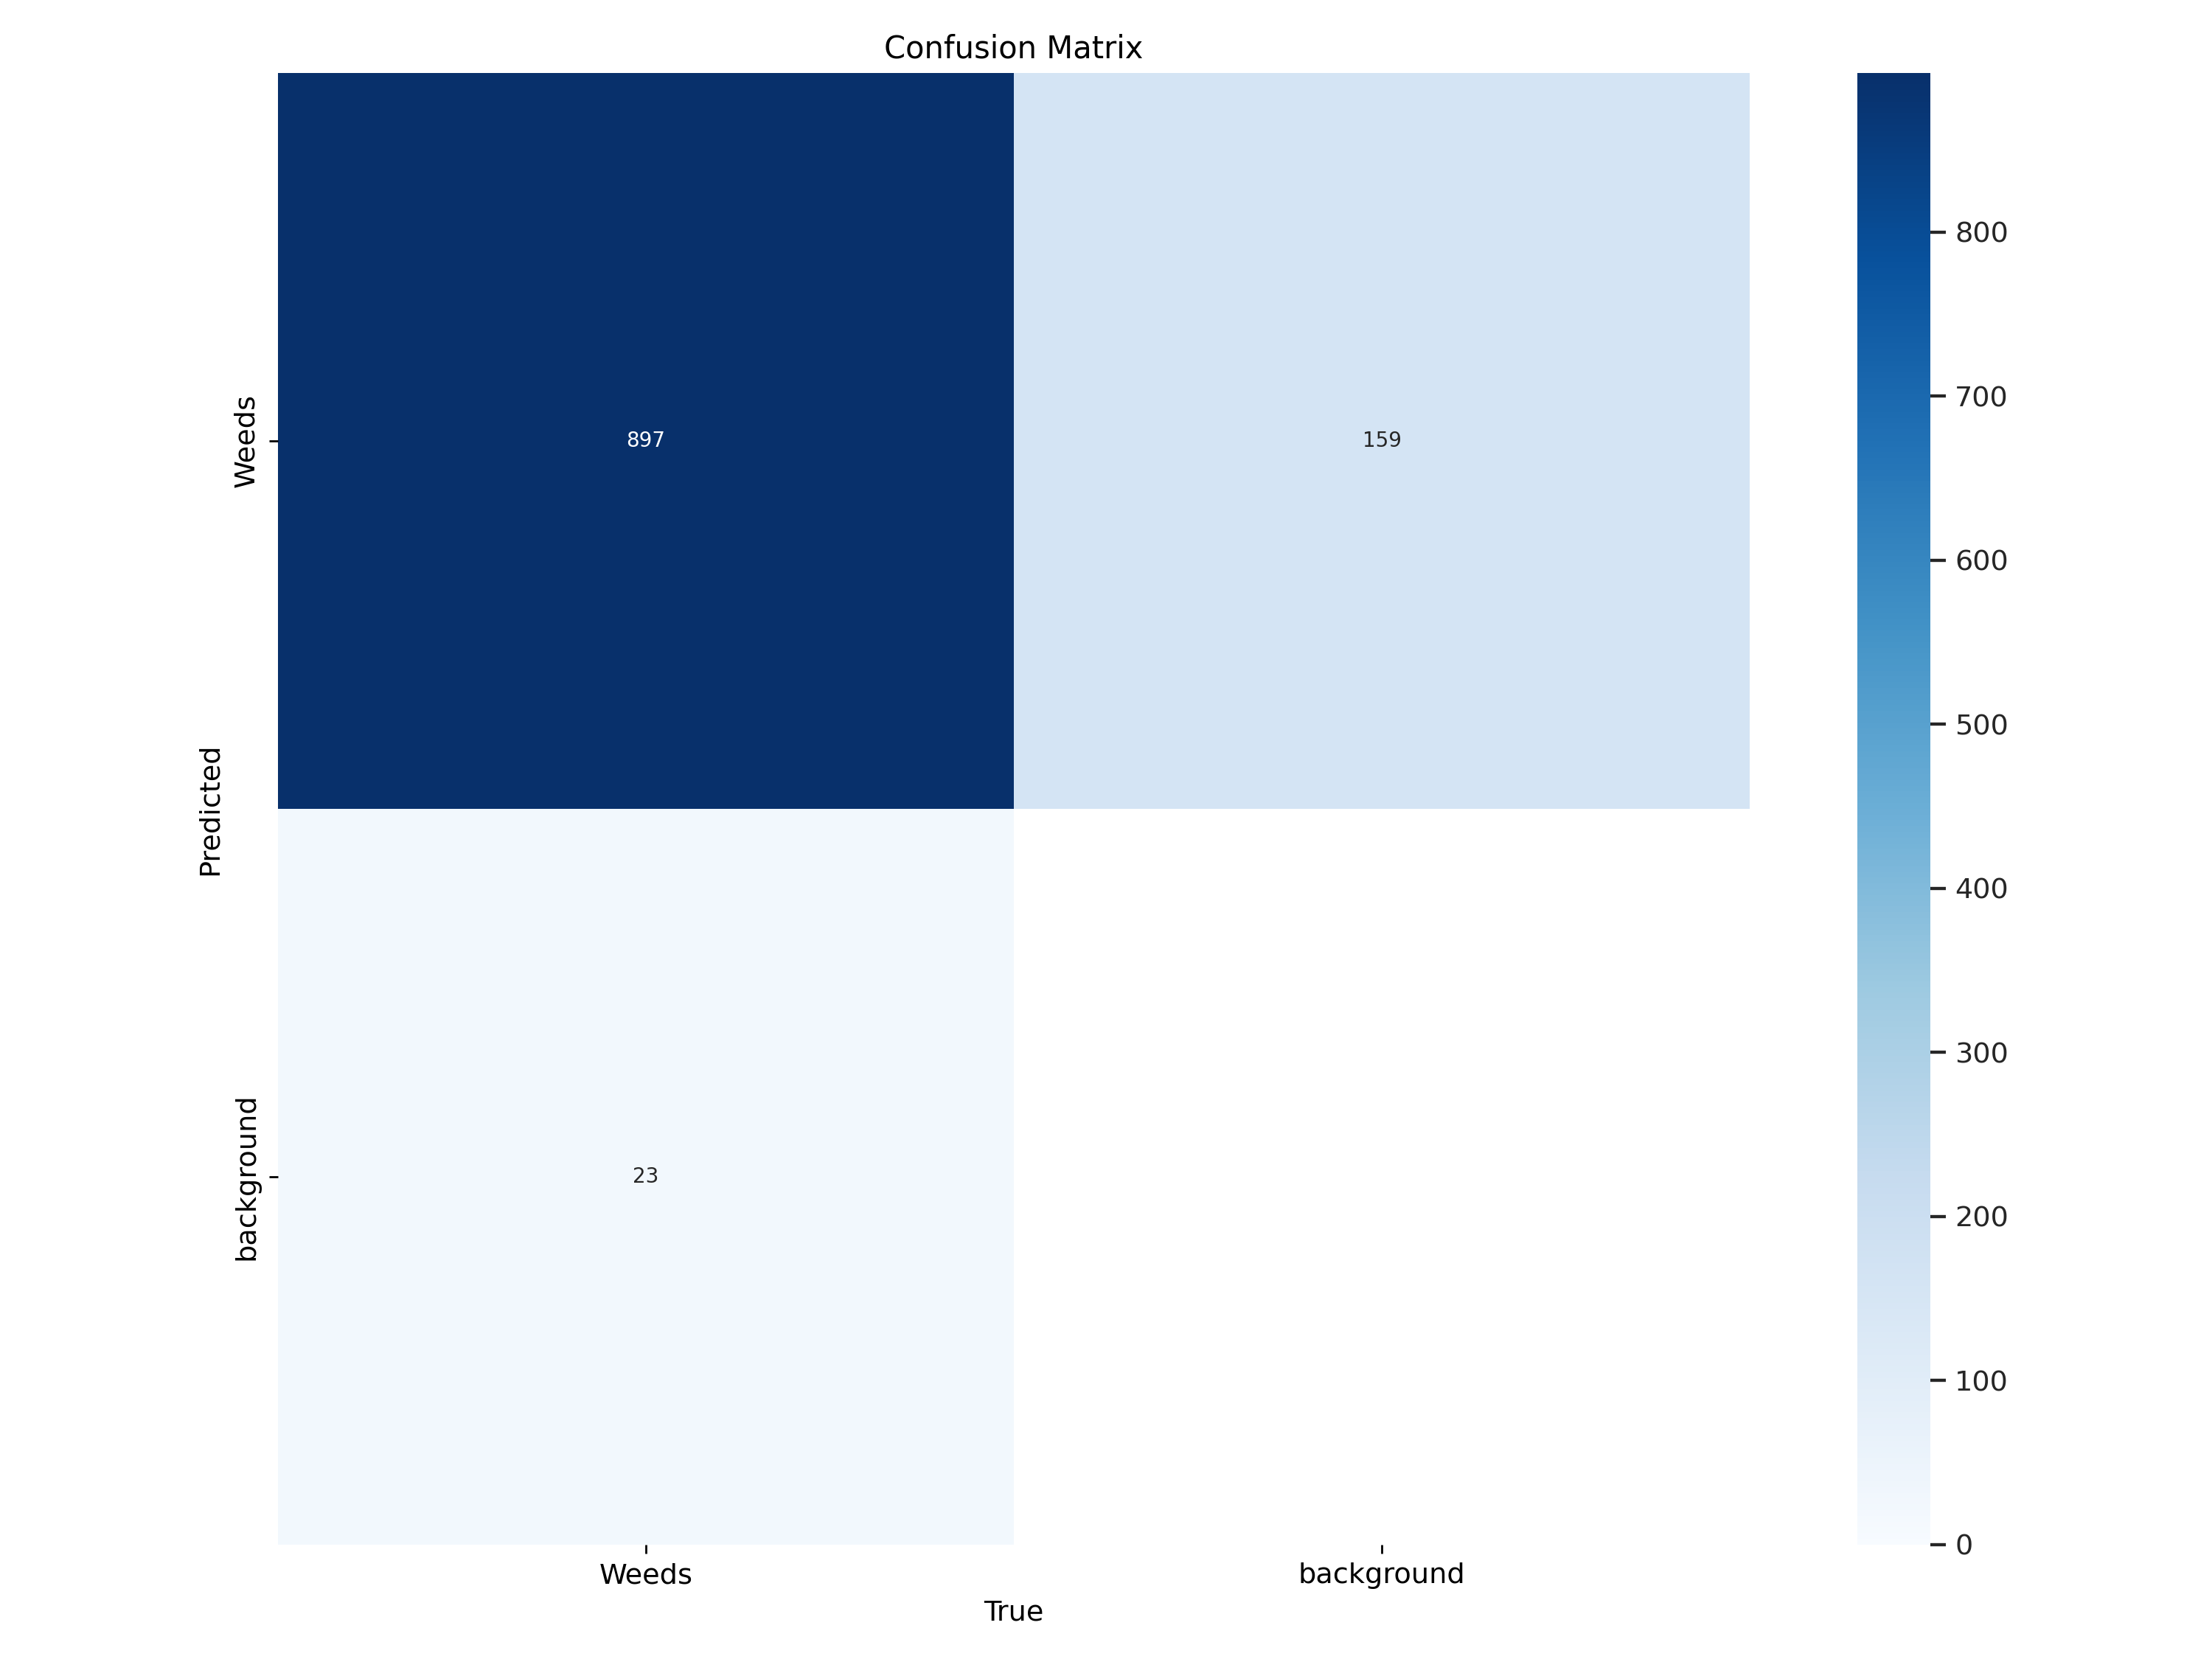

In [14]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=1000)

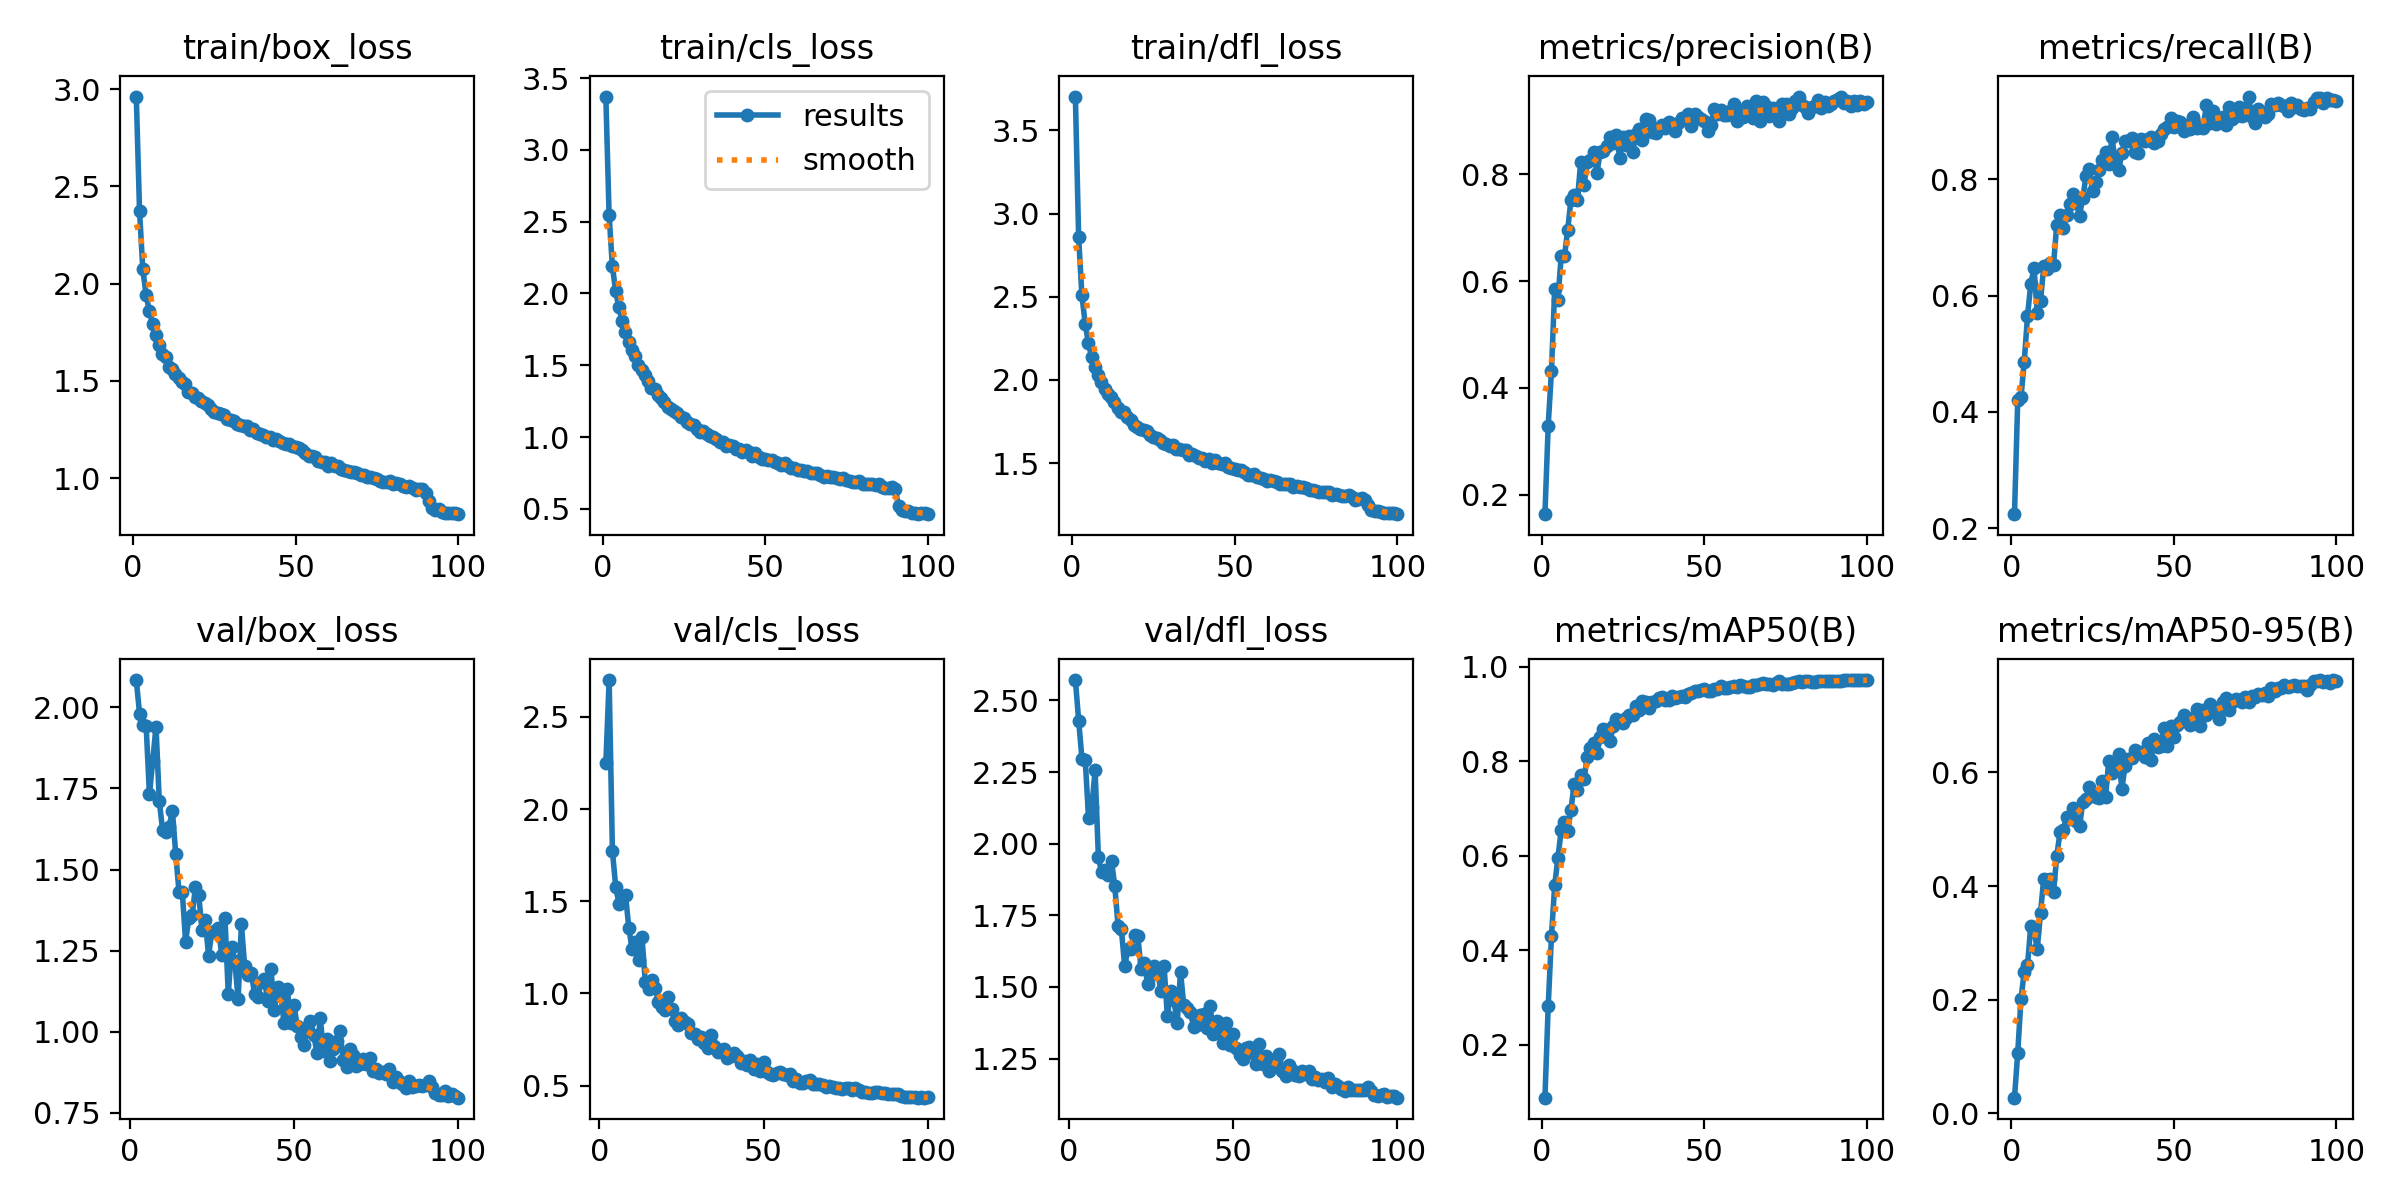

In [15]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/results.png', width=1000)

In [16]:
import supervision as sv

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

ds.classes

['Weeds']

In [17]:
from supervision.metrics import MeanAveragePrecision

model = YOLO(f'/{HOME}/runs/detect/train/weights/best.pt')

predictions = []
targets = []

for _, image, target in ds:
    results = model(image, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)

    predictions.append(detections)
    targets.append(target)

map = MeanAveragePrecision().update(predictions, targets).compute()

In [18]:
print("mAP 50:95", map.map50_95)
print("mAP 50", map.map50)
print("mAP 75", map.map75)

mAP 50:95 0.648740479397401
mAP 50 0.9640181308946848
mAP 75 0.8104518713226937


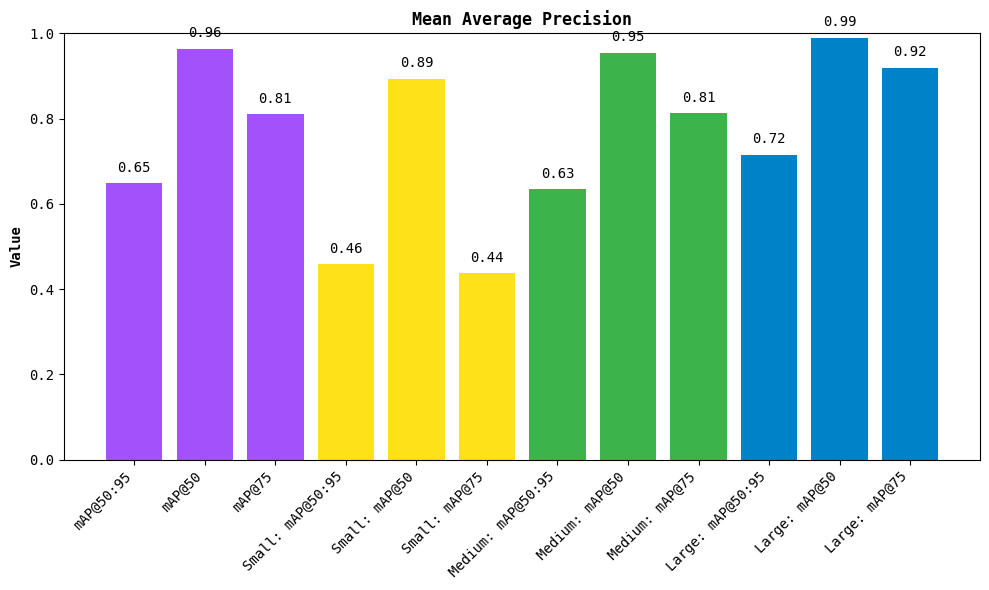

In [19]:
map.plot()

## Run inference with fine-tuned YOLOv12 model

In [20]:
import supervision as sv

model = YOLO(f'/{HOME}/runs/detect/train/weights/best.pt')

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

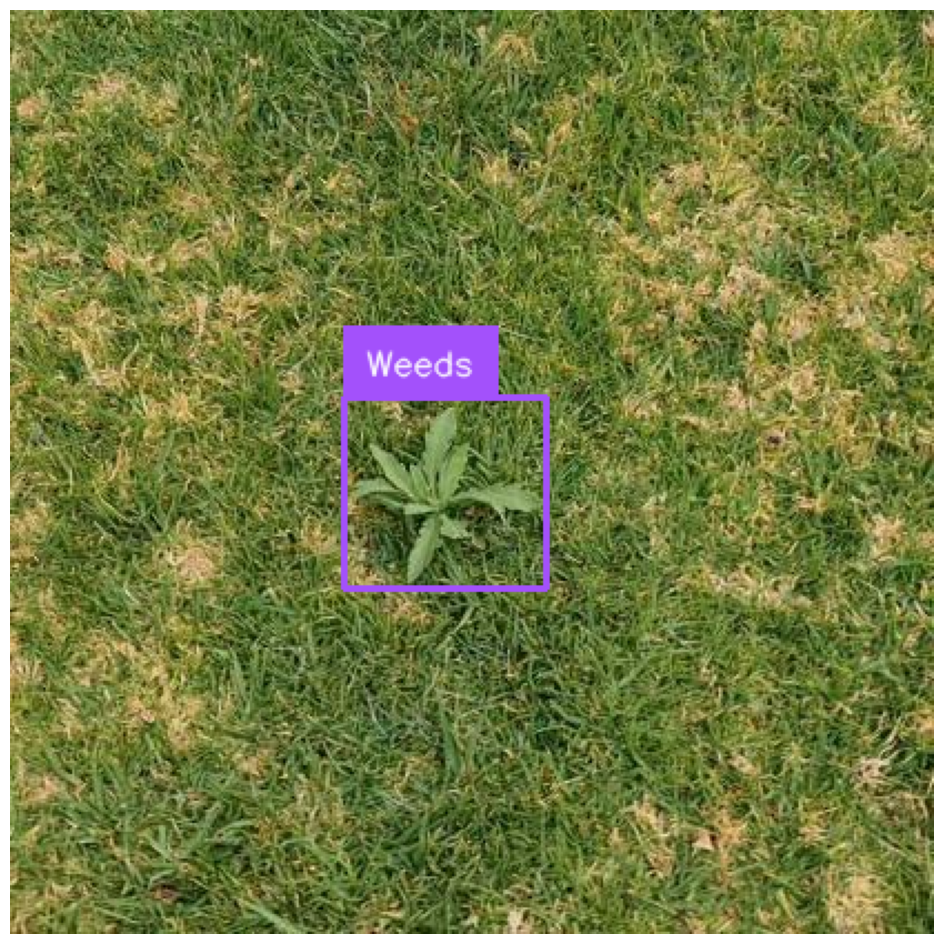

In [21]:
import random

i = random.randint(0, len(ds))

image_path, image, target = ds[i]

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results).with_nms()

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
